# EDA

In [45]:
# Import necessary libralies
import pickle
import numpy as np
import os
import mne
import pandas as pd
import seaborn as sns


import torch   #general pytorch
import torch.nn as nn  #neural network module
import torch.nn.functional as F  #useful functions like softmax, or relu

#pip install torchvision; conda install torchvision
from torchvision import datasets, transforms  #transforms for image processing
from torch.utils.data import DataLoader, Dataset       #dataloader for preparing batch


from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset
from torch.autograd import Variable

In [24]:
import os
main_path = os.getcwd()
filename = os.listdir(main_path + '/Cleaned_signal/')

In [26]:
filename = ['clean_exp1.csv',
 'clean_exp2.csv',
 'clean_exp3.csv',
 'clean_exp4.csv',
 'clean_exp5.csv',
 'clean_exp6.csv',
 'clean_exp7.csv',
 'clean_exp8.csv',
 'clean_exp9.csv',
 'clean_exp10.csv',
 'clean_exp11.csv',
 'clean_exp12.csv',
 'clean_exp13.csv',
 'clean_exp14.csv',
 'clean_exp15.csv',
 'clean_exp16.csv',
 'clean_exp17.csv']

In [35]:
all_file_path = main_path + '/Cleaned_signal/'
X_list = list()
for file in filename:
    file_path = all_file_path + file
    df = pd.read_csv(file_path, index_col=None)
    df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
    X_list.append(df)    

In [36]:
df.head()

,Fp1,Fp2,F7,F3,F4,F8,T3,C3,C4,T4,T5,P3,P4,T6,O1,O2
0,3.388132e-21,1.312901e-19,-9.080193e-19,8.453389e-19,-1.035074e-18,5.302426e-18,-2.879912e-20,1.973587e-18,-1.770299e-18,2.638719e-18,-7.462360e-19,2.486042e-19,-2.623685e-19,-1.321371e-18,-2.126053e-19,-7.919758e-19
1,4.240123e-06,-1.098127e-03,9.504785e-06,-7.301414e-04,-9.864431e-04,5.528234e-06,4.397685e-06,-3.200624e-05,-1.489707e-05,-9.424304e-06,-1.179442e-06,-3.882617e-06,-1.544578e-04,3.472641e-04,-8.418374e-06,-7.045003e-05
2,4.531352e-06,-2.151353e-04,5.921683e-06,-1.464024e-04,-1.963873e-04,7.661865e-06,7.361615e-06,-4.243603e-06,-4.617989e-06,2.459634e-06,2.879465e-06,2.427743e-06,-2.532974e-05,7.922094e-05,-6.490459e-06,-1.263134e-05
3,3.763741e-06,-5.832528e-04,4.345541e-06,-3.864017e-04,-5.199725e-04,4.296499e-06,6.737737e-06,-1.258225e-05,-1.224808e-05,-4.653922e-06,4.127254e-06,1.146176e-06,-7.805786e-05,2.117792e-04,-7.120499e-06,-3.545076e-05
4,-2.243297e-06,-6.780617e-04,1.494894e-06,-4.541781e-04,-6.006397e-04,-1.012771e-06,3.279630e-06,-1.230263e-05,-1.609016e-05,-6.882220e-06,2.642719e-06,-5.242474e-07,-9.300509e-05,2.342439e-04,-7.541476e-06,-4.271908e-05


In [37]:
X = np.array(X_list)
X.shape

(17, 45000, 16)

In [66]:
# Reshape
X = np.transpose(X, (0, 2, 1))
X.shape

(17, 45000, 16)

In [67]:
y_path = '/root/projects/CP/Projects/Signal/label_exp.csv'
df = pd.read_csv(y_path)
y = np.array(df['label'])
y

array([1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1])

In [43]:
# Create dataset
tensor_X = torch.tensor(X)
tensor_y = torch.tensor(y)
dataset = TensorDataset(tensor_X, tensor_y)

In [44]:
for x, y in dataset:
    print(x.shape, y)
    break

torch.Size([16, 45000]) tensor(1)


### Spectral Analysis

In [46]:
# Meta data
ch_names = ['Fp1', 'Fp2', 'F7', 'F3', 'F4', 'F8', 'T3', 'C3', 'C4', 'T4', 'T5', 'P3', 'P4', 'T6', 'O1', 'O2']
ch_types = ['eeg'] * len(ch_names)
sfreq = 125
info = mne.create_info(ch_names=ch_names, ch_types=ch_types, sfreq=sfreq)

# Create epochs
epochs = mne.EpochsArray(tensor_X, info)

# Set headset mapping
epochs.set_montage('standard_1020')
print('------------------')
print(f'{epochs._data.shape=}')
print('------------------')
epochs

Not setting metadata
17 matching events found
No baseline correction applied
0 projection items activated
------------------
epochs._data.shape=(17, 16, 45000)
------------------


Number of events,17
Events,1: 17
Time range,0.000 – 359.992 sec
Baseline,off


In [47]:
# Compute power spectrum density
epoch = epochs.__getitem__(0)
spectrum = epoch.compute_psd(method="welch", n_fft=125) #get Spectrum object from epochs
psds, freqs = spectrum.get_data(return_freqs=True)
print(psds.shape, freqs.shape)

Effective window size : 1.000 (s)
(1, 16, 63) (63,)


In [48]:
# Add log for vissiblity
spectrum = epochs.compute_psd(method='welch', n_fft=125)
psds, freqs = spectrum.get_data(return_freqs=True)
psds = 10 * np.log10(psds)
print(psds.shape, freqs.shape)

Effective window size : 1.000 (s)
(17, 16, 63) (63,)


In [49]:
# 1. First step, find the mean of all channels
psds = psds.mean(axis=1)
psds.shape

(17, 63)

In [50]:
#2. Seperate to the range of bands
# delta 0-3 Hz 
delta = psds[:, :4]
# theta 4-7 Hz
theta = psds[:, 4:8]
# alpha 8-12 Hz
alpha = psds[:, 8:13]
# beta 13-30 Hz
beta = psds[:, 13:31]
# gamma 25-43 Hz
gamma = psds[:, 25:44]
# slow 4-13 Hz
slow = psds[:, 4:14]
# low beta 13-17 Hz
low_beta = psds[:, 13:18]

In [51]:
print(f'delta shape is {delta.shape}')
print(f'theta shape is {theta.shape}')
print(f'alpha shape is {alpha.shape}')
print(f'beta shape is {beta.shape}')
print(f'gamma shape is {gamma.shape}')
print(f'slow shape is {slow.shape}')
print(f'low_beta shape is {low_beta.shape}')

delta shape is (17, 4)
theta shape is (17, 4)
alpha shape is (17, 5)
beta shape is (17, 18)
gamma shape is (17, 19)
slow shape is (17, 10)
low_beta shape is (17, 5)


In [52]:
delta = delta.mean(axis=1).reshape(-1, 1)
theta = theta.mean(axis=1).reshape(-1, 1)
alpha = alpha.mean(axis=1).reshape(-1, 1)
beta = beta.mean(axis=1).reshape(-1, 1)
gamma = gamma.mean(axis=1).reshape(-1, 1)
slow = slow.mean(axis=1).reshape(-1, 1)
low_beta = low_beta.mean(axis=1).reshape(-1, 1)

In [53]:
print(f'delta shape is {delta.shape}')
print(f'theta shape is {theta.shape}')
print(f'alpha shape is {alpha.shape}')
print(f'beta shape is {beta.shape}')
print(f'gamma shape is {gamma.shape}')
print(f'slow shape is {slow.shape}')
print(f'low_beta shape is {low_beta.shape}')

delta shape is (17, 1)
theta shape is (17, 1)
alpha shape is (17, 1)
beta shape is (17, 1)
gamma shape is (17, 1)
slow shape is (17, 1)
low_beta shape is (17, 1)


In [62]:
# Stack them together for ploting
_temp = [delta, theta, alpha, beta, gamma, slow, low_beta]
all_bands = np.hstack(_temp)
all_bands.shape

(17, 7)

In [63]:
# Turn all band into dataframe
df = pd.DataFrame(all_bands, columns= ['delta', 'theta', 'alpha', 'beta', 'gamma', 'slow', 'low_beta'])
df.head()

,delta,theta,alpha,beta,gamma,slow,low_beta
0,-103.855967,-113.474132,-114.980497,-121.669741,-125.276808,-114.309350,-118.880283
1,-106.238841,-113.495096,-109.914336,-120.734402,-122.834981,-112.146374,-119.512280
2,-109.019725,-110.991372,-108.627802,-105.437026,-102.667523,-109.580673,-107.475486
3,-108.867331,-113.982494,-116.637048,-124.604565,-130.265602,-115.976712,-121.469666
4,-108.282874,-114.075776,-115.179914,-120.635756,-127.761296,-114.896325,-116.785763


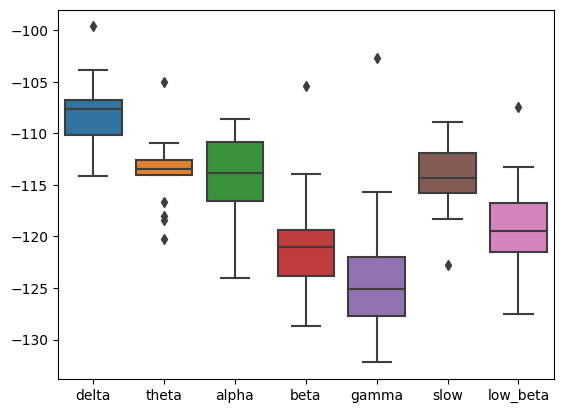

In [64]:
import seaborn as sns
sns.boxplot(data=df)
plt.show()

In [68]:
y

array([1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1])

In [69]:
# Let see if there is any different between bands across stress and non-stress
non_stress = (y==0)
stress = (y==1)
non_stress = all_bands[non_stress]
stress = all_bands[stress]

non_stress.shape, stress.shape

((10, 7), (7, 7))

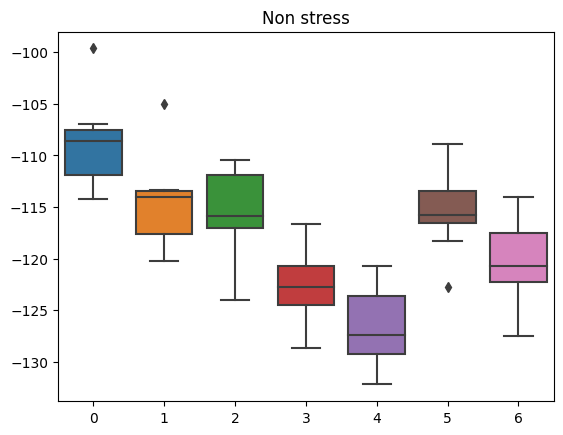

In [70]:
sns.boxplot(data=non_stress)
plt.title('Non stress')
plt.show()

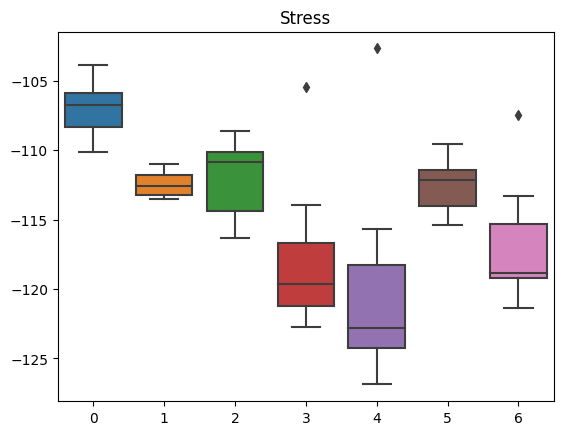

In [71]:
sns.boxplot(data=stress)
plt.title('Stress')
plt.show()

### EDA: Asymmetry

In [77]:
# Chaky code
def df_to_raw(df, convert=False):
    ch_names = ['Fp1', 'Fp2', 'F7', 'F3', 'F4', 'F8', 'T3', 'C3', 'C4', 'T4', 'T5', 'P3', 'P4', 'T6', 'O1', 'O2']
    ch_types = ['eeg'] * len(ch_names)
    df = df.T

    #df[:] *= 1e-6 # mne assume volt data # We already converted in the ETA process

    sampling_rate = 125 #Hz
    info = mne.create_info(ch_names=ch_names, ch_types=ch_types, sfreq=sampling_rate)
    raw = mne.io.RawArray(df, info)
    raw.set_montage('standard_1020')
    # plotting, is not work
    # raw.compute_psd().plot()
    return raw

In [73]:
filename

['clean_exp1.csv',
 'clean_exp2.csv',
 'clean_exp3.csv',
 'clean_exp4.csv',
 'clean_exp5.csv',
 'clean_exp6.csv',
 'clean_exp7.csv',
 'clean_exp8.csv',
 'clean_exp9.csv',
 'clean_exp10.csv',
 'clean_exp11.csv',
 'clean_exp12.csv',
 'clean_exp13.csv',
 'clean_exp14.csv',
 'clean_exp15.csv',
 'clean_exp16.csv',
 'clean_exp17.csv']

In [79]:
# Put data into mne
main_path = os.getcwd()
eeg = dict()

for index, file in enumerate(filename):
    clean_signal_path = main_path + '/Cleaned_signal/' + file
    df = pd.read_csv(clean_signal_path)
    df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
    raw = df_to_raw(df)
    eeg['exp' + str(index)] = raw
    print(f'{file} | time: {len(df)/125}')


Creating RawArray with float64 data, n_channels=16, n_times=45000
    Range : 0 ... 44999 =      0.000 ...   359.992 secs
Ready.
clean_exp1.csv | time: 360.0
Creating RawArray with float64 data, n_channels=16, n_times=45000
    Range : 0 ... 44999 =      0.000 ...   359.992 secs
Ready.
clean_exp2.csv | time: 360.0
Creating RawArray with float64 data, n_channels=16, n_times=45000
    Range : 0 ... 44999 =      0.000 ...   359.992 secs
Ready.
clean_exp3.csv | time: 360.0
Creating RawArray with float64 data, n_channels=16, n_times=45000
    Range : 0 ... 44999 =      0.000 ...   359.992 secs
Ready.
clean_exp4.csv | time: 360.0
Creating RawArray with float64 data, n_channels=16, n_times=45000
    Range : 0 ... 44999 =      0.000 ...   359.992 secs
Ready.
clean_exp5.csv | time: 360.0
Creating RawArray with float64 data, n_channels=16, n_times=45000
    Range : 0 ... 44999 =      0.000 ...   359.992 secs
Ready.
clean_exp6.csv | time: 360.0
Creating RawArray with float64 data, n_channels=16, 

In [81]:
# Get freqeuency
def get_freq(info):
    raw = info
    power, freq = mne.time_frequency.psd_welch(raw,n_fft=125, verbose=True)
    return freq
    
for name, info in eeg.items():
    freq = get_freq(info)
    print(freq)
    break

Effective window size : 1.000 (s)
[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47. 48. 49. 50. 51. 52. 53.
 54. 55. 56. 57. 58. 59. 60. 61. 62.]


<decorator-gen-223>:4: FutureWarning: NOTE: psd_welch() is a deprecated function. Function ``psd_welch()`` is deprecated; for Raw/Epochs/Evoked instances use ``spectrum = instance.compute_psd(method="welch")`` instead, followed by ``spectrum.get_data(return_freqs=True)``.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


In [82]:
band_names = np.array(['Delta', 'Theta', 'Alpha', 'Beta', 'Gamma', 'Slow', 'Low_beta'])
filter_list = [[1,3],[4,7],[8,12],[13,30],[30,43], [4,13], [13,17]]
# band_names = np.array(['Delta', 'Theta', 'Alpha', 'Slow', 'Low_beta'])
# filter_list = [[1,3],[4,7],[8,12], [4,13], [13,17]]
bands = []
for filt in filter_list:
    pt = np.argwhere((freq >= filt[0]) & (freq <= filt[1])).reshape(-1)
    bands.append(pt)
bands = np.array(bands)
print(bands)

[array([1, 2, 3]) array([4, 5, 6, 7]) array([ 8,  9, 10, 11, 12])
 array([13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29,
        30])
 array([30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43])
 array([ 4,  5,  6,  7,  8,  9, 10, 11, 12, 13])
 array([13, 14, 15, 16, 17])]


/tmp/ipykernel_15271/3271316881.py:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  bands = np.array(bands)


In [101]:
#Asymmetry 
features = None
for name, info in eeg.items():
    raw = info
    feature = None
    slow, gamma = None, None
    a_f3, a_f4 = None, None
    a_t7, a_t8 = None, None
    b_f3, b_f4 = None, None
    b_t7, b_t8 = None, None
    #epochs = mne.Epochs(raw, np.array([[125*60*1, 0, 1]]), tmin=0, tmax=30, baseline=(0,30), verbose=False)
    epochs = raw

    print(f'name: {name}')


    for index, band in enumerate(bands):
        
        power,freq = mne.time_frequency.psd_welch(epochs,n_fft=125, verbose=False)
        power = power.squeeze()
        power = 10 * np.log10(power)
        data = power[::,band].mean(axis=1).reshape(1,-1)
        # for asym
        if(band_names[index] == 'Alpha'):
            a_f3 = data[:,raw.ch_names.index('F3')]
            a_f4 = data[:,raw.ch_names.index('F4')]
            # We use t3 as t7 and t4 as t8
            a_t7 = data[:,raw.ch_names.index('T3')]
            a_t8 = data[:,raw.ch_names.index('T4')]
        if(band_names[index] == 'Beta'):
            b_f3 = data[:,raw.ch_names.index('F3')]
            b_f4 = data[:,raw.ch_names.index('F4')]
            # We use t3 as t7 and t4 as t8
            b_t7 = data[:,raw.ch_names.index('T3')]
            b_t8 = data[:,raw.ch_names.index('T4')]

        ####### Mean for visualization #######
        data = data.mean().reshape(1,-1)
        # for relative gamma
        if(band_names[index] == 'Slow'): 
            slow = data
        if(band_names[index] == 'Gamma'): 
            gamma = data

        if(type(feature) == type(None)): 
            print(f'type feature == None band name = {band_names[index]} value = {data}')
            feature = data
        else:
            print(f'band name = {band_names[index]} value = {data}')
            feature = np.concatenate([feature, data], axis=1)
    # print(feature.shape)
    # the eighth feature: relative gamma is slow/gamma
    relative_gamma = slow/gamma
    feature = np.concatenate([feature, relative_gamma], axis=1)

    print(f'relative gamma {relative_gamma}')

    # The asymetry
    alpha_frontal = ((a_f4 - a_f3) / (a_f4 + a_f3)).reshape(1,-1)
    feature = np.concatenate([feature, alpha_frontal], axis=1)

    print(f'alpha_frontal {alpha_frontal}')

    # alpha_temporal
    alpha_temporal = ((a_t8 - a_t7) / (a_t8 + a_t7)).reshape(1,-1)
    feature = np.concatenate([feature, alpha_temporal], axis=1)

    print(f'alpha_temportal {alpha_temporal}')

    # alpha_asymmetry
    alpha_asymmetry = alpha_frontal + alpha_temporal
    feature = np.concatenate([feature, alpha_asymmetry], axis=1)

    print(f'alpha_asymmetry {alpha_asymmetry}')

    # beta_frontal
    beta_frontal = ((b_f4 - b_f3) / (b_f4 + b_f3)).reshape(1,-1)
    feature = np.concatenate([feature, beta_frontal], axis=1)

    print(f'beta_frontal {beta_frontal}')


    # beta_temporal
    beta_temporal = ((b_t8 - b_t7) / (b_t8 + b_t7)).reshape(1,-1)
    feature = np.concatenate([feature, beta_temporal], axis=1)

    print(f'beta_temporal {beta_temporal}')

    # print(slow/gamma)
    # print(feature.shape)
    # print(feature)
    # info['all'] = feature
    #print(feature.shape)
    if(type(features) == type(None)): features = feature
    else: features = np.concatenate([features, feature], axis=0)

print(features.shape)
print('=' * 100)

name: exp0
type feature == None band name = Delta value = [[-102.65835512]]
band name = Theta value = [[-113.47413193]]
band name = Alpha value = [[-114.98049713]]
band name = Beta value = [[-121.66974125]]
band name = Gamma value = [[-125.72644562]]
band name = Slow value = [[-114.30935043]]


<decorator-gen-223>:4: FutureWarning: NOTE: psd_welch() is a deprecated function. Function ``psd_welch()`` is deprecated; for Raw/Epochs/Evoked instances use ``spectrum = instance.compute_psd(method="welch")`` instead, followed by ``spectrum.get_data(return_freqs=True)``.


band name = Low_beta value = [[-118.88028285]]
relative gamma [[0.90919098]]
alpha_frontal [[0.00032554]]
alpha_temportal [[-0.00485743]]
alpha_asymmetry [[-0.00453189]]
beta_frontal [[-0.00111216]]
beta_temporal [[0.00072213]]
name: exp1
type feature == None band name = Delta value = [[-105.1922872]]
band name = Theta value = [[-113.4950956]]
band name = Alpha value = [[-109.9143359]]
band name = Beta value = [[-120.73440161]]
band name = Gamma value = [[-123.08717688]]
band name = Slow value = [[-112.14637449]]
band name = Low_beta value = [[-119.51228006]]
relative gamma [[0.91111339]]
alpha_frontal [[0.00341809]]
alpha_temportal [[0.00187545]]
alpha_asymmetry [[0.00529354]]
beta_frontal [[-0.00819965]]
beta_temporal [[0.000647]]
name: exp2
type feature == None band name = Delta value = [[-107.59897875]]
band name = Theta value = [[-110.99137192]]
band name = Alpha value = [[-108.62780225]]
band name = Beta value = [[-105.43702621]]
band name = Gamma value = [[-102.20578429]]
band n

In [96]:
features.shape

(17, 13)

In [103]:
features[2]

array([-1.07598979e+02, -1.10991372e+02, -1.08627802e+02, -1.05437026e+02,
       -1.02205784e+02, -1.09580673e+02, -1.07475486e+02,  1.07215725e+00,
        1.37293016e-02, -1.59341865e-03,  1.21358830e-02,  2.33852787e-02,
       -8.27803126e-04])

Explaination
```
name: exp2
band name = Delta value = [[-107.59897875]]
band name = Theta value = [[-110.99137192]]
band name = Alpha value = [[-108.62780225]]
band name = Beta value = [[-105.43702621]]
band name = Gamma value = [[-102.20578429]]
band name = Slow value = [[-109.58067261]]
band name = Low_beta value = [[-107.47548593]]
relative gamma [[1.07215725]]
alpha_frontal [[0.0137293]]
alpha_temportal [[-0.00159342]]
alpha_asymmetry [[0.01213588]]
beta_frontal [[0.02338528]]
beta_temporal [[-0.0008278]]
```

In [108]:
feature_column = ['Delta', 'Theta', 'Alpha', 'Beta', 'Gamma', 'Slow', 'Low_beta', 'Relative_gamma', 'Alpha_frontal', 'Alpha_temporal',
'Alpha_asymmetry', 'Beta_Frontal', 'Beta_temporal', 'label']

In [139]:
print(features.shape, y.shape)

(17, 13) (17,)


In [118]:
df = pd.DataFrame(features, columns=feature_column)
#df['label'] = y
df.head()

,Delta,Theta,Alpha,Beta,Gamma,Slow,Low_beta,Relative_gamma,Alpha_frontal,Alpha_temporal,Alpha_asymmetry,Beta_Frontal,Beta_temporal
0,-102.658355,-113.474132,-114.980497,-121.669741,-125.726446,-114.309350,-118.880283,0.909191,0.000326,-0.004857,-0.004532,-0.001112,0.000722
1,-105.192287,-113.495096,-109.914336,-120.734402,-123.087177,-112.146374,-119.512280,0.911113,0.003418,0.001875,0.005294,-0.008200,0.000647
2,-107.598979,-110.991372,-108.627802,-105.437026,-102.205784,-109.580673,-107.475486,1.072157,0.013729,-0.001593,0.012136,0.023385,-0.000828
3,-107.591149,-113.982494,-116.637048,-124.604565,-131.335318,-115.976712,-121.469666,0.883058,-0.000171,0.001438,0.001267,0.003436,0.014656
4,-106.986591,-114.075776,-115.179914,-120.635756,-129.173273,-114.896325,-116.785763,0.889474,0.005878,0.001046,0.006923,0.005253,0.002142


<AxesSubplot: >

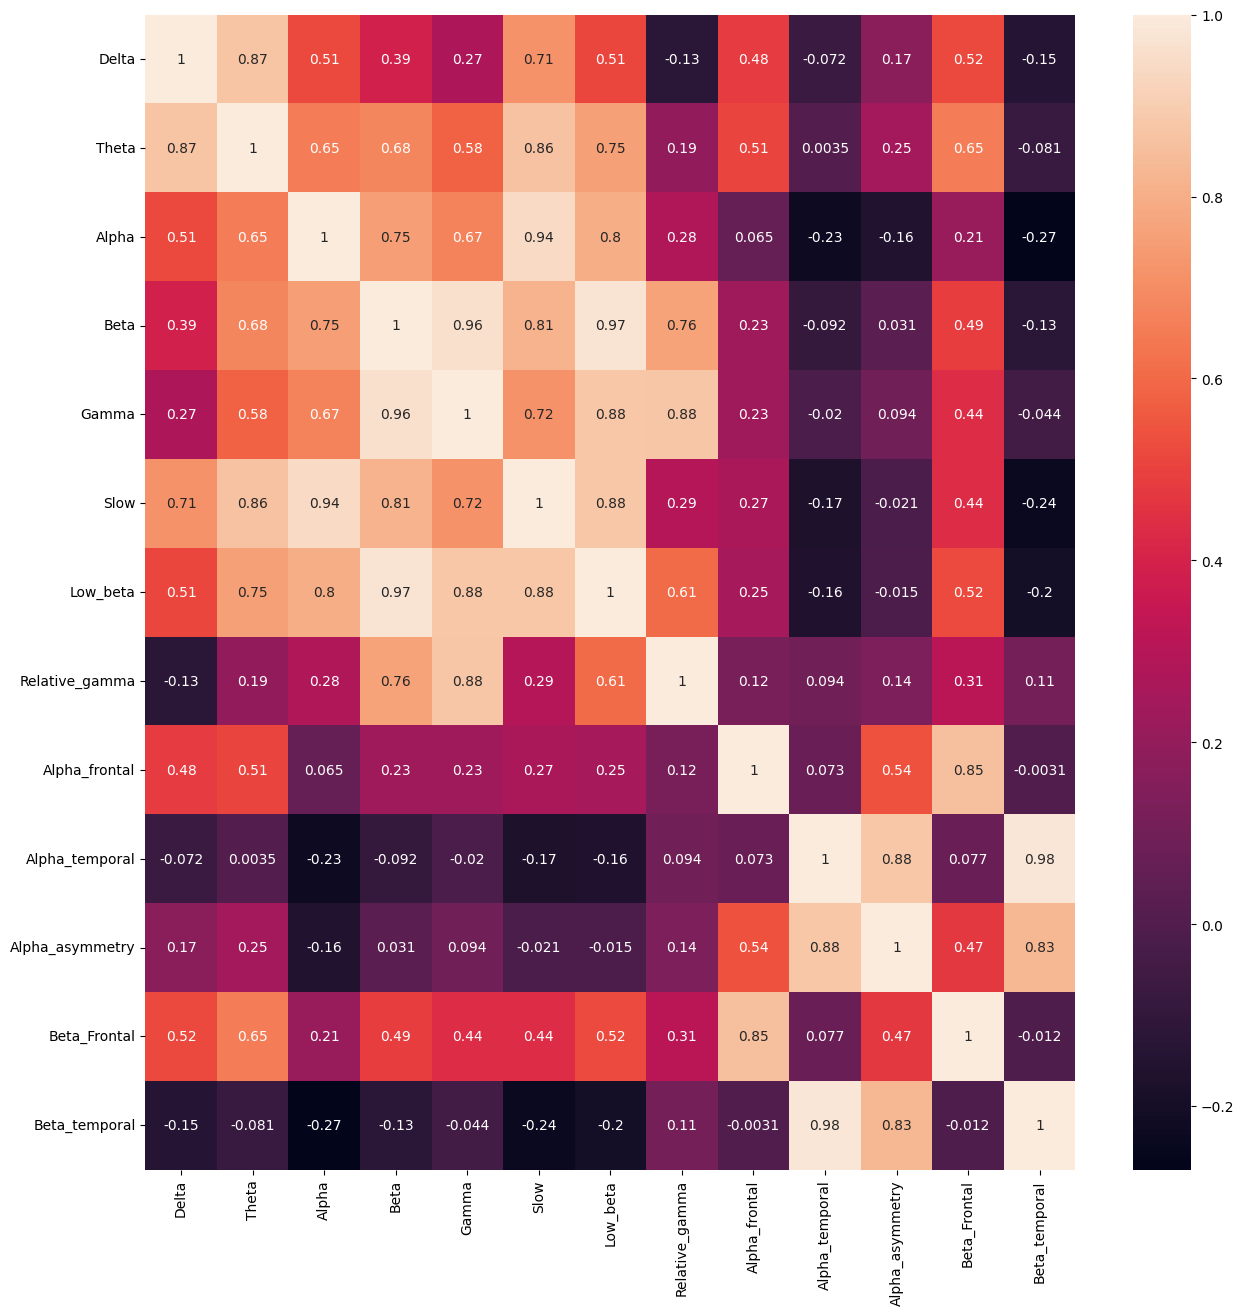

In [119]:
plt.figure(figsize=(15, 15))
sns.heatmap(df.corr(), annot=True)

In [134]:
asymmetry = features[:, 7:]
asymmetry.shape

(17, 6)

In [135]:
# Let check the result of feature engineering.
df = pd.DataFrame(asymmetry, columns=['Relative_gamma', 'Alpha_frontal', 'Alpha_temporal',
'Alpha_asymmetry', 'Beta_Frontal', 'Beta_temporal'])
df.head()

,Relative_gamma,Alpha_frontal,Alpha_temporal,Alpha_asymmetry,Beta_Frontal,Beta_temporal
0,0.909191,0.000326,-0.004857,-0.004532,-0.001112,0.000722
1,0.911113,0.003418,0.001875,0.005294,-0.008200,0.000647
2,1.072157,0.013729,-0.001593,0.012136,0.023385,-0.000828
3,0.883058,-0.000171,0.001438,0.001267,0.003436,0.014656
4,0.889474,0.005878,0.001046,0.006923,0.005253,0.002142


<AxesSubplot: >

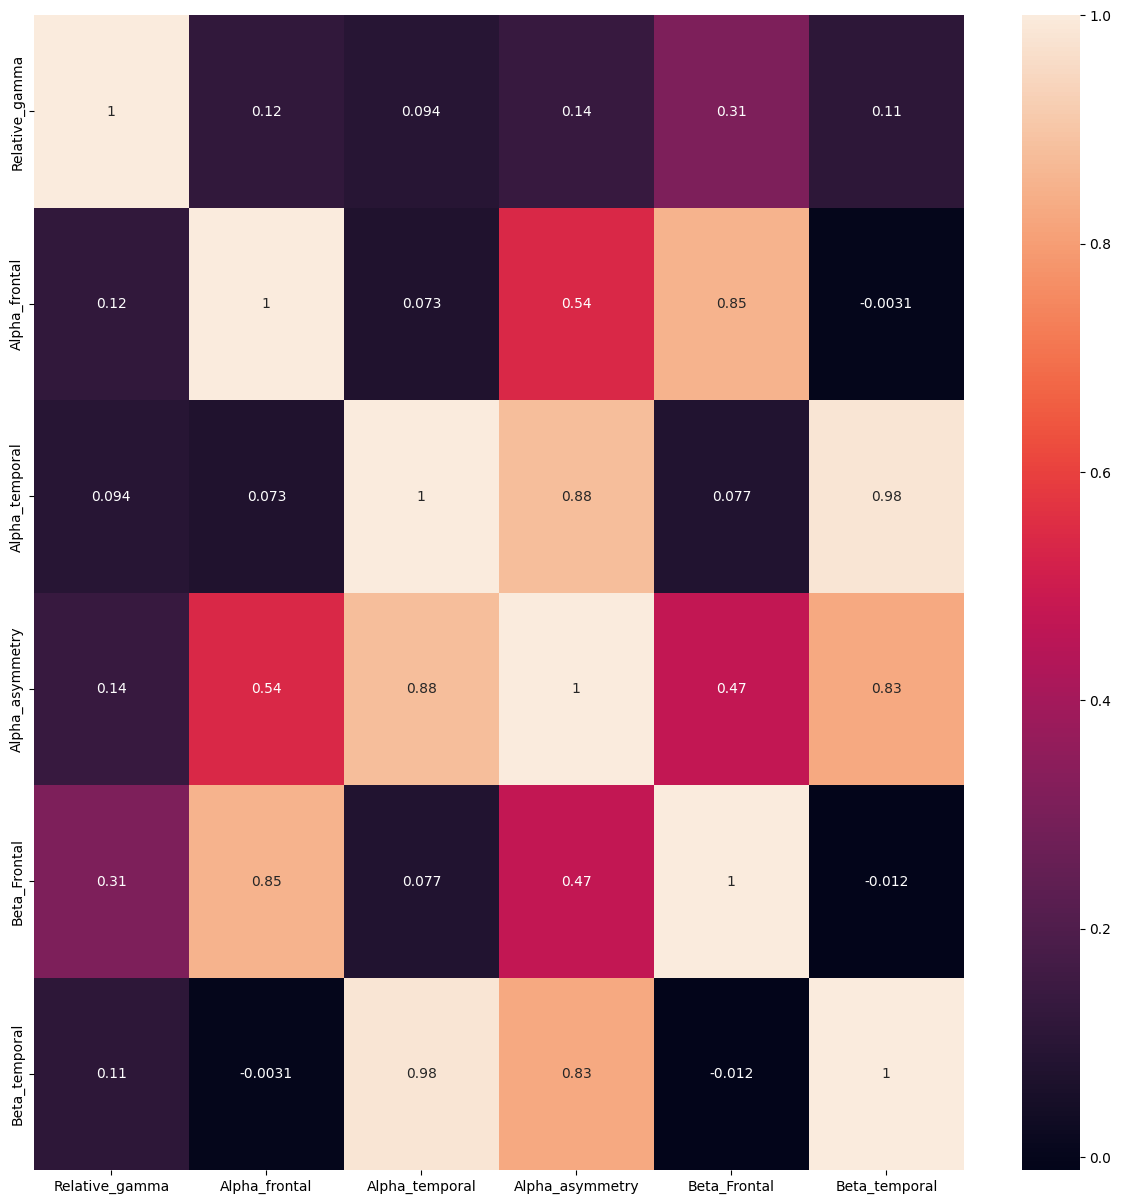

In [136]:
plt.figure(figsize=(15, 15))
sns.heatmap(df.corr(), annot=True)

In [141]:
asymmetry.shape

(17, 6)

In [ ]:
# Stack them together for ploting
_temp = [delta, theta, alpha, beta, gamma, slow, low_beta]
all_bands = np.hstack(_temp)
all_bands.shape

In [137]:
feature_name = ['Relative_gamma', 'Alpha_frontal', 'Alpha_temporal',
'Alpha_asymmetry', 'Beta_Frontal', 'Beta_temporal']

In [142]:
# Let see if there is any different between bands across stress and non-stress
non_stress = (y==0)
stress = (y==1)
non_stress = asymmetry[non_stress]
stress = asymmetry[stress]

non_stress.shape, stress.shape

((10, 6), (7, 6))

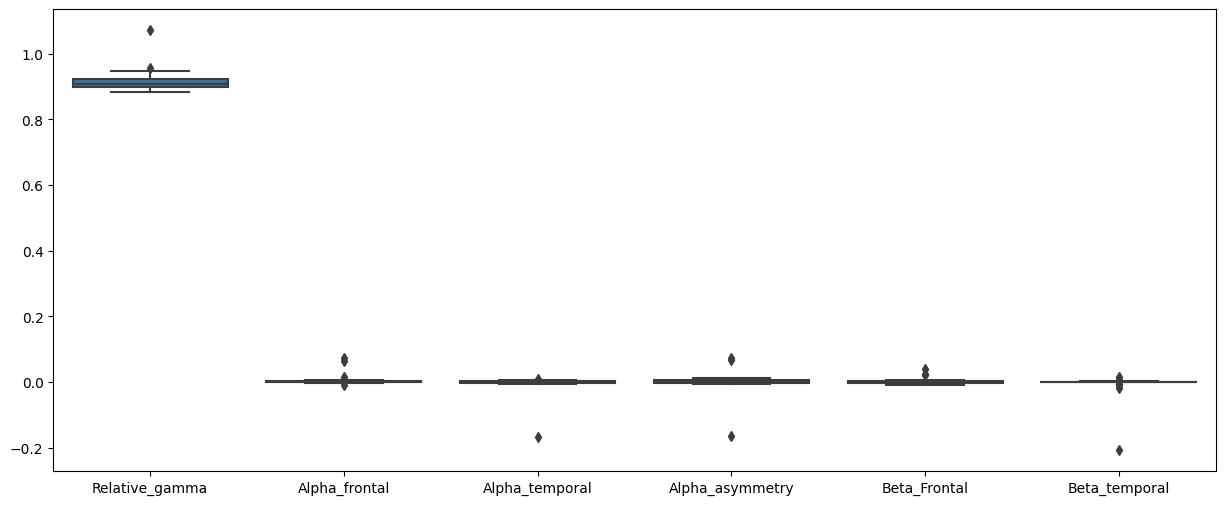

In [144]:
plt.figure(figsize=(15, 6))
sns.boxplot(data=df)
plt.show()

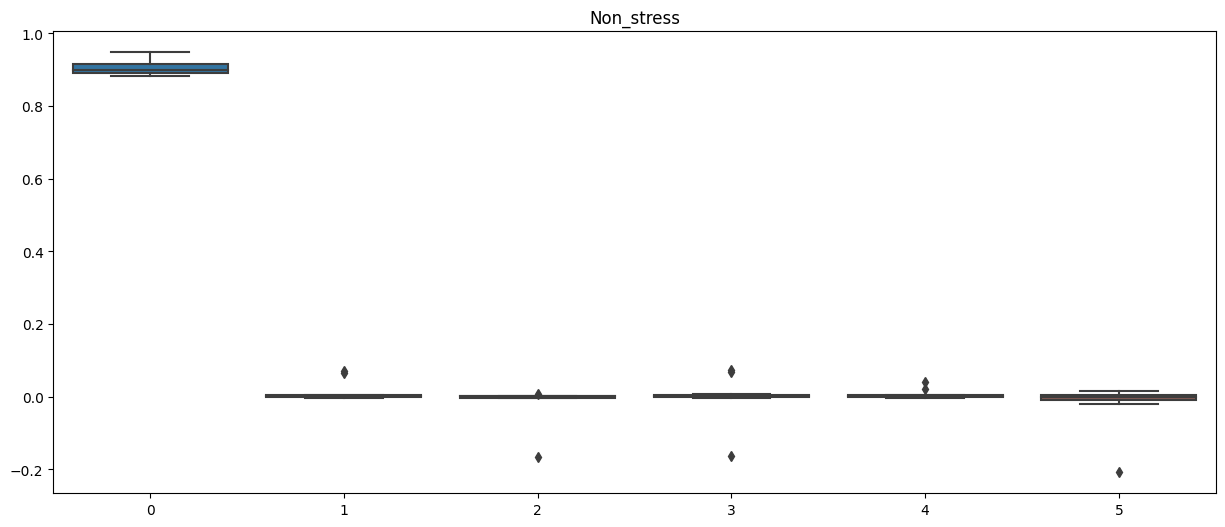

In [147]:
plt.figure(figsize=(15, 6))
sns.boxplot(data=non_stress)
plt.title('Non_stress')
#plt.xlabel('Test')
plt.show()

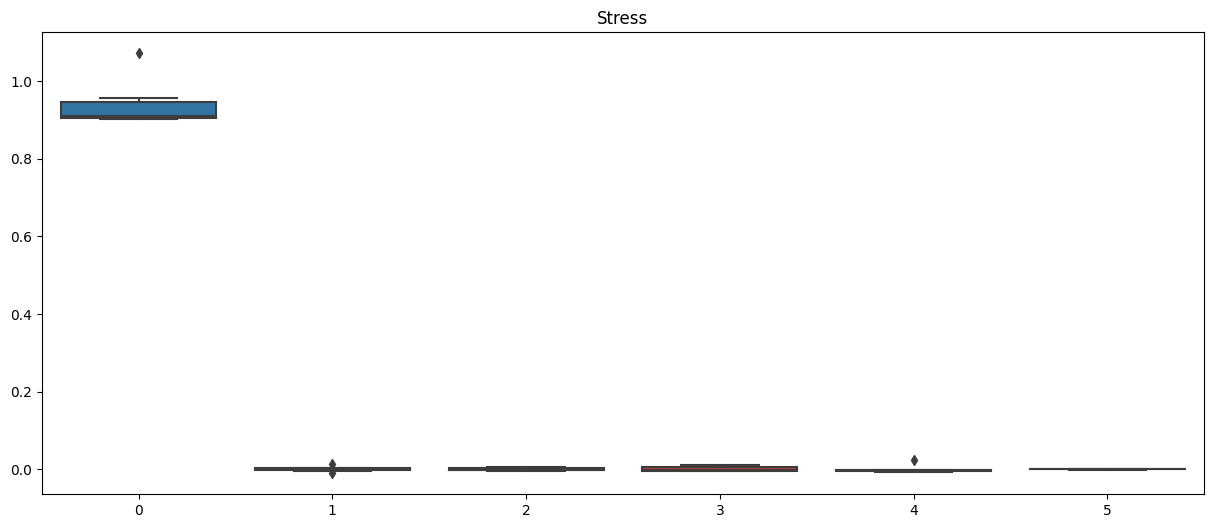

In [149]:
plt.figure(figsize=(15, 6))
sns.boxplot(data=stress)
plt.title('Stress')
#plt.xlabel('Test')
plt.show()